In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0


In [2]:
# Install our repo
# !git clone -b models "https://github.com/ab7289-tandon-nyu/GraphVision.git"
# !cp -r /content/GraphVision/src/ .

!pip install -q git+https://github.com/ab7289-tandon-nyu/GraphVision.git

In [3]:
from src.transforms import get_transforms
from src.datasets import get_datasets, get_dataloaders

transforms = get_transforms("cartesian")
train_dataset, valid_dataset, test_dataset = get_datasets(".data/", 
                        "MNIST", pre_transforms = None,
                        transforms = transforms)
BATCH_SIZE = 64

train_loader, valid_loader, test_loader = get_dataloaders(train_dataset,
                                                          valid_dataset,
                                                          test_dataset,
                                                          batch_size=(BATCH_SIZE, 1, 1),
                                                          drop_last = False)

Extracting .data/MNIST/raw/MNIST_v2.zip
Processing...
Done!


## Review batch attributes

In [4]:
sample_batch = next(iter(train_loader))

print()
print(sample_batch)
print("=====================================================================")

# Gather some statistics about the first graph.
print(f"Number of features:  {sample_batch.num_features}")
print(f"Number of node features: {sample_batch.num_node_features}")
print(f'Number of nodes: {sample_batch.num_nodes}')
print(f'Number of edges: {sample_batch.num_edges}')
print(f'Average node degree: {sample_batch.num_edges / sample_batch.num_nodes:.2f}')
print(f'Has isolated nodes: {sample_batch.has_isolated_nodes()}')
print(f'Has self-loops: {sample_batch.has_self_loops()}')


DataBatch(x=[4531, 1], edge_index=[2, 40779], edge_attr=[40779, 2], y=[64], pos=[4531, 2], edge_weight=[40779], batch=[4531], ptr=[65])
Number of features:  1
Number of node features: 1
Number of nodes: 4531
Number of edges: 40779
Average node degree: 9.00
Has isolated nodes: False
Has self-loops: True


In [5]:
# store edge dimension
edge_dim = sample_batch.edge_attr.size(-1)
edge_dim
# store number of features in graph batch
input_features = test_dataset.num_features
# store number of classes for classification
num_classes = test_dataset.num_classes

In [6]:
from pathlib import Path

save_loc = "../saved_models/" # put save location here
model_name = "GENConv_clus-false_BN_RELU_layer4.pt"

file_path = save_loc + model_name
path = Path(file_path)
state_dict = None
if path.exists() and path.is_file():
  print("Found Save!")
  state_dict = torch.load(path)
else:
  print("Creating new Model")

Creating new Model


## Create our Model

In [7]:
from src.models import DeeperGCN

hidden_features = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperGCN(
    input_features,
    num_classes,
    hidden_features,
    conv_type = "GEN",
    act = "gelu",
    norm = "layer",
    num_layers = 4,
    use_cluster_pooling = True,
    readout = "mean",
    dropout = 0.0,
    edge_dim = edge_dim
).to(device)
if state_dict is not None:
  print("Loading previously saved state dictionary")
  model.load_state_dict(state_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [8]:
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"There are {params:,} trainable parameters.")
print()
print(model)

There are 68,366 trainable parameters.

DeeperGCN(
  (fc_in): Linear(in_features=1, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
  (out_act): GELU(approximate='none')
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
  )
)


## Train

In [10]:
from src.engine import train, evaluate
from src.utils import calculate_accuracy

EPOCHS = 15
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
best_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
  print(f"\nEpoch: {epoch}\n")
  loss, acc = train(model, train_loader, criterion, optimizer, device)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Train Loss: {train_loss[-1]:.3f}, Train Accuracy: {train_acc[-1]:.2f}")

  loss, acc = evaluate(model, valid_loader, criterion, device)
  valid_loss.append(loss)
  valid_acc.append(acc)
  print(f"Validation Loss: {valid_loss[-1]:.3f}, Validation Accuracy: {valid_acc[-1]:.2f}")

  if loss < best_loss:
    best_loss = loss
    torch.save(model.state_dict(), path)


Epoch: 1

Train Loss: 0.307, Train Accuracy: 0.90
Validation Loss: 2.792, Validation Accuracy: 0.28

Epoch: 2

Train Loss: 0.244, Train Accuracy: 0.92
Validation Loss: 1.287, Validation Accuracy: 0.65

Epoch: 3

Train Loss: 0.209, Train Accuracy: 0.93
Validation Loss: 0.707, Validation Accuracy: 0.80

Epoch: 4

Train Loss: 0.186, Train Accuracy: 0.94
Validation Loss: 0.542, Validation Accuracy: 0.83

Epoch: 5

Train Loss: 0.170, Train Accuracy: 0.94
Validation Loss: 0.482, Validation Accuracy: 0.86

Epoch: 6

Train Loss: 0.156, Train Accuracy: 0.95
Validation Loss: 0.241, Validation Accuracy: 0.92

Epoch: 7

Train Loss: 0.144, Train Accuracy: 0.95
Validation Loss: 1.076, Validation Accuracy: 0.72

Epoch: 8

Train Loss: 0.134, Train Accuracy: 0.96
Validation Loss: 0.658, Validation Accuracy: 0.81

Epoch: 9

Train Loss: 0.126, Train Accuracy: 0.96
Validation Loss: 0.372, Validation Accuracy: 0.89

Epoch: 10

Train Loss: 0.120, Train Accuracy: 0.96
Validation Loss: 0.382, Validation Accu

## Evaluate on the Test set

In [ ]:
# load best model
model.load_state_dict(torch.load(path))
test_loss, test_acc = evaluate(model.to(device), test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.195
Test Accuracy: 0.94%


## Plot Loss and Accuracy Curves

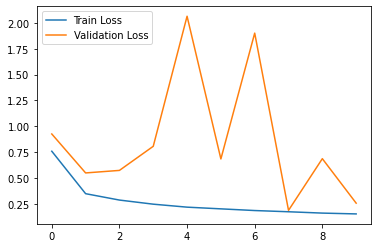

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(len(valid_loss))]

plt.plot(x, train_loss, label="Train Loss")
plt.plot(x, valid_loss, label="Validation Loss")
plt.legend()
plt.show()

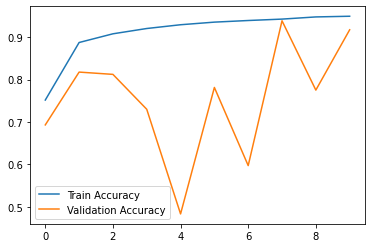

In [ ]:
plt.plot(x, train_acc, label="Train Accuracy")
plt.plot(x, valid_acc, label="Validation Accuracy")
plt.legend()
plt.show()